# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [40]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
import cv2

We set the random seed so that the results don't vary drastically.

In [21]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [189]:
train_doc = np.random.permutation(open('C:/Users/nibu01/Documents/UpGrad/Assignments/Gesture Recognition/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/nibu01/Documents/UpGrad/Assignments/Gesture Recognition/Project_data/Project_data/val.csv').readlines())
batch_size = 15

## Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [190]:
#Image Parameters
img_idx = [2,3,5,7,9,11,13,15,16,17,18,19,20,21,22,23,24,25,26]
x = len(img_idx)
y=120#image_height
z=160#image_width
z_crop=100

In [209]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    while True:
        t = np.random.permutation(folder_list)
        num_batches,partial_batches = divmod(len(folder_list),batch_size)
        if num_batches>0:
            batch_data, batch_labels = batch_process(x,y,z,num_batches,batch_size,source_path,img_idx,t)
            yield batch_data, batch_labels
            print(len(batch_labels))
        # write the code for the remaining data points which are left after full batches    
        elif partial_batches>0:
            batch_data, batch_labels = batch_process(x,y,z,partial_batches,batch_size,source_path,img_idx,t)
            yield batch_data, batch_labels

        
        
def batch_process(x,y,z,num_batches,batch_size,source_path,img_idx,t):
    for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z_crop,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #Resizing the image to 120X160
                    #print("Before Resizing:::")
                    #print(image.shape)
                    image_resized=imresize(image,(y,z,3))
                    #print("After Resizing:::")
                    #print(image_resized.shape)
                    #Cropping the image as the first and last 20 pixels have no useful information
                    image_cropped = image_resized[0:120, 20:120]
                    #print("After Cropping")
                    #print(image_cropped.shape)
                    #plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)) # converting BGR to RGB for using matplotlib
                    #plt.show()
                    batch_data[folder,idx,:,:,0] = (image_cropped[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_cropped[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_cropped[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            return (batch_data,batch_labels) #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [231]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/nibu01/Documents/UpGrad/Assignments/Gesture Recognition/Project_data/Project_data/train'
val_path = 'C:/Users/nibu01/Documents/UpGrad/Assignments/Gesture Recognition/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 1# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 1


In [208]:
#test_generator = generator(train_path, train_doc, batch_size)

In [193]:
#next(test_generator)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [224]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv2D,Conv3D,MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
#write your model here

In [211]:
#Defining the frames,No.of rows etc
input_shape=(x,y,z_crop,3)
featuremap = [8,16,32,64]
dense = [128,64,5]
classes = 5

In [212]:
model = Sequential()
model.add(TimeDistributed(Conv2D(featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense[1], activation='relu'))
model.add(Dropout(0.25))
model.add(GRU(128, return_sequences=False))
model.add(Dense(dense[2], activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [213]:
optimiser = Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_64 (TimeDis (None, 19, 60, 50, 8)     224       
_________________________________________________________________
time_distributed_65 (TimeDis (None, 19, 60, 50, 16)    1168      
_________________________________________________________________
time_distributed_66 (TimeDis (None, 19, 30, 25, 16)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 19, 30, 25, 32)    4640      
_________________________________________________________________
time_distributed_68 (TimeDis (None, 19, 15, 12, 32)    0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 19, 15, 12, 64)    8256      
_________________________________________________________________
time_distributed_70 (TimeDis (None, 19, 7, 6, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [214]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [199]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [200]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [215]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:/Users/nibu01/Documents/UpGrad/Assignments/Gesture Recognition/Project_data/Project_data/train ; batch size = 15


C:\Users\nibu01\Documents\Python\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\nibu01\Documents\Python\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


15
45/45 [==============================] - ETA: 0s - loss: 1.2801 - categorical_accuracy: 0.4667Source path =  C:/Users/nibu01/Documents/UpGrad/Assignments/Gesture Recognition/Project_data/Project_data/val ; batch size = 15
15
15
15
15
15
15
15

Epoch 00001: saving model to model_init_2020-10-3122_36_07.387523\model-00001-1.28008-0.46667-1.57699-0.31429.h5
45/45 [==============================] - 83s 2s/step - loss: 1.2801 - categorical_accuracy: 0.4667 - val_loss: 1.5770 - val_categorical_accuracy: 0.3143


In [219]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

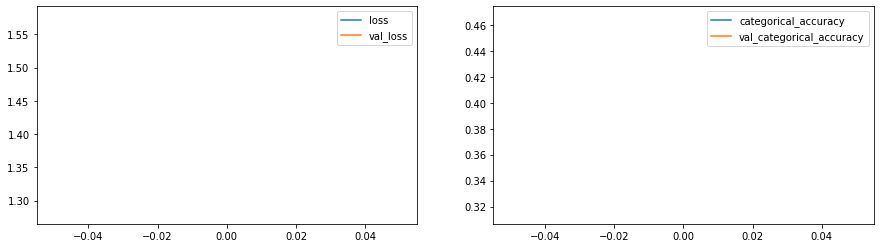

In [220]:
plot(history)

In [229]:
model_lstm = Sequential()
model_lstm.add(LSTM(2048, return_sequences=False,input_shape=(1000,5),dropout=0.5))
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(5, activation='softmax'))

In [230]:
optimiser = Adam(0.001)
model_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_lstm.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2048)              16826368  
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 2565      
Total params: 17,878,021
Trainable params: 17,878,021
Non-trainable params: 0
_________________________________________________________________
None


In [232]:
lstm_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

15


C:\Users\nibu01\Documents\Python\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\nibu01\Documents\Python\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


15
45/45 [==============================] - ETA: 0s - loss: 0.7808 - categorical_accuracy: 0.685915
15
15
15
15
15
15
15

Epoch 00001: saving model to model_init_2020-10-3122_36_07.387523\model-00001-0.78084-0.68593-1.51670-0.39048.h5
45/45 [==============================] - 81s 2s/step - loss: 0.7808 - categorical_accuracy: 0.6859 - val_loss: 1.5167 - val_categorical_accuracy: 0.3905
